# Домашнее задание № 7 

In [1]:
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor

import os
import cv2
import skimage
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import RANSACRegressor
# from PCV.geometry import homography
# from PCV.localdescriptors import sift

# Поиск объектов в видеопотоке 

Задача - придумать и реализовать алгоритм поиска (обнаружения без классификации) движущихся объектов.

В качестве исходных данных приведена выборка с видеофайлами и аннотацией для каждого кадра файла. Аннотация задана в виде ограничивающих прямоугольников в формате ```(y1,x1,y2,x2)```, где
- ```(x1,y1)``` - верхний левый угол прямоугольника;
- ```(x2,y2)``` - нижний правый угол прямоугольника.

Ссылка на данные – https://disk.yandex.ru/d/RdjMDoQQO8Ngcw

В качестве обучающей можно брать любые видеофайлы. При этом должны быть отдельно выбраны тестовые данные, которые не будут использованы в создании решения. 

Видеофайл с результатами работы алгоритма должен быть прикреплен вместе с решением. Пример фрагмента видеофайла с результатом поиска объектов приведен ниже.

Исходный код может быть в формате ```.py``` или ```.ipynb```.

![annotation](annot_example.gif "annotation")

## Требования к результату
- поиск должен находить геометрические место объекта на видеоизображении. Геометрическое место задано ограничивающим прямоугольником (bounding box);
- продолжительность решения для любого одного видеофайла не должна превышать 10 минут;
- должна быть приведена оценка точности решения;
- привести демонстрацию результатов требется на одном из тестовых видеофайлов.

In [20]:
# вспомогательная функция
def plot_one_image(src_image, is_gray=False):
    """
    Отрисовать с помощью plt исходное изображение.
    
    :param src_image: np.ndarray: исходное изображение
    :param is_gray: bool: флаг для отображения ЧБ изображений
    :return: None
    """
    fig, m_axs = plt.subplots(1, 1, figsize=(6*2, 4*2), constrained_layout=True)
    ax1 = m_axs

    cmap = 'gray' if is_gray else None
    ax1.set_title('Исходное изображение')
    ax1.imshow(src_image, cmap=cmap)
    ax1.set_xticks([]), ax1.set_yticks([])
    plt.show()

In [21]:
def get_transform_point(M, point):
    v = np.array([[point[0]], [point[1]], [1]])
    trans = M@v
    new_x = np.sum(trans[0])/np.sum(trans[2])
    new_y = np.sum(trans[1])/np.sum(trans[2])
    return np.array([new_x, new_y])

In [22]:
class Trajectory:
    def __init__(self, idx):
        self.points = []
        self.d = 0
        self.idx = idx
    
    def add_point(self, point):
        self.points.append(np.array(point))
    
    def get_last(self):
        return self.points[-1]
    
    def set_last(self, point):
        self.d += np.sum(np.abs(point-self.points[-1]))
        self.points[-1] = np.array(point)
    
    def get_trajectory_len(self):
        return len(self.points)
    
    def add_d(self, d):
        self.d += d
        
    def get_d(self):
        return self.d
    
    def get_point(self, idx):
        if idx < self.idx or self.idx+self.get_trajectory_len()-1 < idx:
            return np.array([-1,-1])
        return self.points[idx-self.idx]
    
    def get_start_idx(self):
        return self.idx
    
    def get_end_idx(self):
        return self.idx+self.get_trajectory_len()-1

In [38]:
class Trajectories:
    def __init__(self):
        self.trajectories = []
        self.save_trajectories = []
        self.calc_all_tr = False
        
    def get_last_points(self):
        temp_list = self.trajectories
        if self.calc_all_tr:
            temp_list = self.trajectories + self.save_trajectories
        return np.float32([np.array([trajectory.get_last()]) for trajectory in temp_list])
    
    
    def continue_trajectories(self, new_points, old_points, idx):
        last_points = np.array([trajectory.get_last() for trajectory in self.trajectories])
        if len(last_points) == 0:
            for point in new_points:
                self.trajectories.append(Trajectory(idx))
                self.trajectories[-1].add_point(point)
                return
            
        count_trajectories = len(self.trajectories)
        temp_ind = list(range(count_trajectories))
        
        calc_ind = []
        last_i = len(old_points)
        for i, point in enumerate(old_points):
            if len(last_points) == 0:
                last_i = i
                break

            dists = np.abs(last_points[:,0] - point[0]) + np.abs(last_points[:,1] - point[1])
            ind = np.argmin(dists)
            if dists[ind] < 20:
                self.trajectories[temp_ind[ind]].add_point(new_points[i])
                self.trajectories[temp_ind[ind]].add_d(dists[ind])
                calc_ind.append(temp_ind[ind])
                last_points = np.delete(last_points, ind, axis=0)
                temp_ind.pop(ind)
            else:
                self.trajectories.append(Trajectory(idx))
                self.trajectories[-1].add_point(new_points[i])
        
        if last_i != len(old_points):
            for i in range(last_i, len(old_points)):
                self.trajectories.append(Trajectory(idx))
                self.trajectories[-1].add_point(new_points[i])
        
#         print('cmp len', count_trajectories, len(calc_ind))
        calc_ind = set(calc_ind)
        all_ind = set(range(count_trajectories))
        del_ind = list(set(calc_ind) ^ set(all_ind))
        del_ind = sorted(del_ind, reverse=True)
        for ind in del_ind:
            self.save_trajectories.append(self.trajectories[ind])
            self.trajectories.pop(ind)
    
    def get_trajectories_len(self):
        temp_list = self.trajectories
        if self.calc_all_tr:
            temp_list = self.trajectories + self.save_trajectories
        return np.array([trajectory.get_trajectory_len() for trajectory in temp_list])
    
    def get_trajectories_dist(self):
        temp_list = self.trajectories
        if self.calc_all_tr:
            temp_list = self.trajectories + self.save_trajectories
        return np.array([trajectory.get_d() for trajectory in temp_list])
          
    def get_points(self, idx):
        temp_list = self.trajectories
        if self.calc_all_tr:
            temp_list = self.trajectories + self.save_trajectories
        return np.array([trajectory.get_point(idx) for trajectory in temp_list])
    
    def load_all_trajectories(self):
        self.calc_all_tr = True
#         self.trajectories = self.trajectories + self.save_trajectories
    
    def del_save_trajectories(self):
        self.calc_all_tr = False
        
    def get_trajectories(self):
        temp_list = self.trajectories
        if self.calc_all_tr:
            temp_list = self.trajectories + self.save_trajectories
        return temp_list
    
    def get_trajectories_last_idx(self):
        temp_list = self.trajectories
        if self.calc_all_tr:
            temp_list = self.trajectories + self.save_trajectories
        return np.array([trajectory.get_end_idx() for trajectory in temp_list])

In [39]:
def create_video(save_dir, size, img_format='jpg', vido_format='avi'):
    out_name = Path(save_dir).parts[-1]

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(str(Path(save_dir) / Path(f'{out_name}.{vido_format}')),
                          fourcc, 20, tuple(size.astype(int)))

    for fname in tqdm(sorted(map(str, Path(save_dir).glob(f'*.{img_format}')))):
        imag = skimage.io.imread(fname)
        imag = cv2.cvtColor(imag, cv2.COLOR_RGB2BGR)
        out.write(imag)
    out.release()

In [40]:
def show_video(num=-1,path='./tmp/', sleep=0):
    cap = get_video(num if num >=0 else 0, path=path)
    get_video_details(cap)
    cv2.startWindowThread()
    while (cap.isOpened()):
        is_ok, frame = cap.read()
        if not is_ok:
            break
            
        if sleep > 0:
            time.sleep(sleep)

        cv2.imshow("sparse optical flow", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

In [41]:
def spec_points(image):
    """
    Функция для поиска особых точек и получения их дескрипторов 
    """
    
    hyp_params = dict(
        nfeatures = 100,
        nOctaveLayers = 10,
        contrastThreshold = 0.005,
        edgeThreshold = 6,
        sigma = 2.0)  # hyp params
    detector = cv2.SIFT_create(**hyp_params)

    keypoints, desc = detector.detectAndCompute(image.copy(), None)
    return keypoints, desc

In [42]:
def get_keyp_and_d(first, second):
    FLANN_INDEX_KDTREE = 2
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    ratio_thresh = 0.55
    keypoints1, desc1 = spec_points(first)
    keypoints2, desc2 = spec_points(second)
    
    matches = flann.knnMatch(desc1, desc2, k=2)
    
    good_matches = []
    for m, n in matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)
    
    return keypoints1, keypoints2, good_matches

In [43]:
def get_M(first, second):
    h, w = first.shape
    
    
    keypoints1, keypoints2, good_matches = get_keyp_and_d(first, second)
    
    pts1 = []
    pts2 = []   
    
    for good_matche in good_matches:
        pts1.append(keypoints1[good_matche.queryIdx].pt)
        pts2.append(keypoints2[good_matche.trainIdx].pt)
    
    pts1 = np.array(pts1).astype(np.float32)
    pts2 = np.array(pts2).astype(np.float32)
    
    model = RANSACRegressor()
    model.fit(pts1, pts2)

    points1 = np.array([[0,0], [0,h], [w,0], [w,h]]).astype(np.float32)
    points2 = model.predict(points1).astype(np.float32)
    M = cv2.getPerspectiveTransform(points1, points2)
    return M, model
    

In [44]:
def get_good_points(image, frame, k_size=3):
    hsv_frame = cv2.cvtColor(frame.copy(), cv2.COLOR_BGR2HSV)
    
    mask = np.uint8((image > 5)*255)
#     kernel = np.ones((k_size, k_size), np.uint8)
#     mask = cv2.erode(mask, kernel, iterations=1)
    
    p = np.where(mask != 0)
    y = p[0]
    x = p[1]
    all_points = np.array(list(zip(x, y)))
    
    points = np.array([all_points[0]])
    
    for point in all_points:
        if np.min(np.abs(points[:,0] - point[0]) + np.abs(points[:,1] - point[1])) > 3:
            h = hsv_frame[point[1], point[0], 0]
#             if h < 10 or h > 100:
            if h > 100:
                points = np.r_[points, [point]]
    
#     print('points', points)
#     gg = np.array([hsv_frame[point[1],point[0], 0] for point in points]).astype(np.uint8)
#     print(type(gg[0]))
#     hist = cv2.calcHist([gg], [0], None, [180], [0, 180])
#     plt.plot(hist)
#     plt.show()
#     if len(points) < 10:
#         return get_good_points(image, frame, k_size=3)
    points = np.array([[np.float32(point)] for point in points])
    return points

In [45]:
def del_stick(list_trajectories, w, h):
    good_trajectories = []
    for trajectory in list_trajectories:
        points = np.array(trajectory.points)
        if np.any(points[:, 0] > w//4) or np.any(points[:, 1] < h//3):
            good_trajectories.append(trajectory)
            
    return good_trajectories  

In [46]:
def draw_trajectories(list_image, trajectories):
    trajectories.load_all_trajectories()
    color = (0, 255, 0)
    last_idx = len(list_image)-1
    tr_lens = trajectories.get_trajectories_len()
    tr_dist = trajectories.get_trajectories_dist()
    tr_end_idx = trajectories.get_trajectories_last_idx()
    print(len(tr_end_idx))
    print(len(tr_lens))
    count, val = np.unique(tr_dist[tr_dist>5], return_counts=True)
    plt.plot(val, count)
    plt.show()
    print(tr_dist)
    inds = (np.where(((tr_lens > 15) | (tr_end_idx == last_idx)) & (tr_dist/tr_lens > 3))[0]).tolist()
    good_trajectories = [trajectory for i, trajectory in enumerate(trajectories.get_trajectories()) if i in inds]
    
    h, w, _ = list_image[0].shape
    good_trajectories = del_stick(good_trajectories, w, h)
    
    for idx in tqdm(range(len(list_image))):
        image = list_image[idx]
        points = np.array([trajectory.get_point(idx) for trajectory in good_trajectories])
        points = points[points[:,0] != -1]
        output = image.copy()
        for point in points:
            output = cv2.circle(output, (point[0], point[1]), 3, color, -1)
        cv2.imwrite(f'tmp2/frame_{str(idx).zfill(4)}.jpg', output)
    
    trajectories.del_save_trajectories()

100246
100246


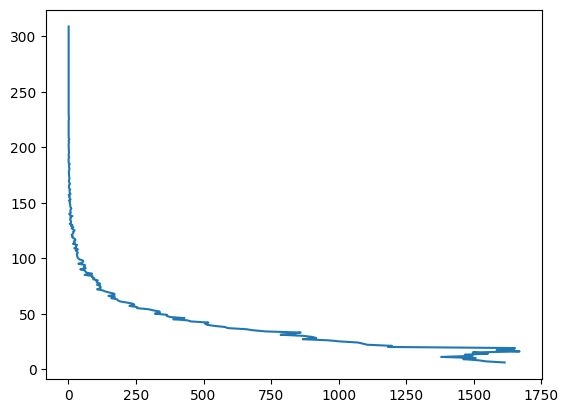

[162 309 147 ...  80  95  71]


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

tmp2.mp4
101.0 1920.0 1080.0 20.0


In [49]:
draw_trajectories(list_frames, trajectories)
create_video('tmp2', size=np.array((1920.0 , 1080.0)), vido_format='mp4')
show_video(path='./tmp2/', sleep=0.1)

In [47]:
def get_trajectory(cap, max_idx=-1, create_vid=True):
    cnt, w, h, fps = get_video_details(cap)
    cnt = int(cnt)
    color = (0, 255, 0)
    feature_params = dict(maxCorners=1000, qualityLevel=0.02, minDistance=2, blockSize=7)
    lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    
    is_ok, first_frame = cap.read()
    if not is_ok:
        print("ERR: Can't read")
        return
    
    prev_gray = cv2.cvtColor(first_frame.copy(), cv2.COLOR_BGR2GRAY)
    mask = np.zeros_like(first_frame)
    idx = 0
    trajectories = Trajectories()
    list_frames = []
    for idx in tqdm(range(cnt-1)):
        if not cap.isOpened():
            break
        if max_idx > 0 and idx > max_idx:
            break
        is_ok, frame = cap.read()
        if not is_ok:
            break
        
        list_frames.append(frame.copy())
        gray = cv2.cvtColor(frame.copy(), cv2.COLOR_BGR2GRAY)
        mask = np.zeros_like(frame)
        
        M, model = get_M(prev_gray.copy(), gray.copy())
        trans_prev_gray = cv2.warpPerspective(prev_gray.copy(), M, (prev_gray.shape[1], prev_gray.shape[0]))

        
        trans_gray = gray*(trans_prev_gray!=0).astype(np.uint8)
        nice_pic = np.abs(trans_prev_gray.astype(int)-trans_gray.astype(int)).astype(np.uint8)
        prev = get_good_points(nice_pic, frame)
        
        nextp, status, error = cv2.calcOpticalFlowPyrLK(trans_prev_gray, trans_gray, prev, None, **lk_params)
        
        good_old = prev[status == 1].astype(int)
        good_new = nextp[status == 1].astype(int)

        new_points = []
        old_points = []
        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = new.ravel()
            c, d = old.ravel()
            mask = cv2.line(mask, (a, b), (c, d), color, 2)
            frame = cv2.circle(frame, (a, b), 3, color, -1)
            new_points.append(np.array([a, b]))
            old_points.append(np.array([c, d]))
        trajectories.continue_trajectories(new_points, old_points, idx)

        output = cv2.add(frame, mask)
        prev_gray = gray.copy()
 
        cv2.imwrite(f'tmp/frame_{str(idx).zfill(4)}.jpg', output)

    cap.release()
#     draw_trajectories(list_frames, trajectories)
    return trajectories, list_frames

In [48]:
cap = get_video(2)
trajectories, list_frames = get_trajectory(cap, 100, True)
# create_video('tmp', size=np.array((1920.0 , 1080.0)), vido_format='mp4')


Clip_03.mov
1800.0 1920.0 1080.0 29.97


  0%|          | 0/1799 [00:00<?, ?it/s]

In [ ]:
create_video('tmp2', size=np.array((1920.0 , 1080.0)), vido_format='mp4')

In [32]:
show_video(path='./tmp2/', sleep=0.1)

tmp2.mp4
101.0 1920.0 1080.0 20.0


In [ ]:
draw_trajectories(list_frames, trajectories)

In [450]:
tr_lens = trajectories.get_trajectories_len()
tr_dist = trajectories.get_trajectories_dist()
print('count trajectories', len(tr_lens))
tr_dist = tr_dist[tr_lens > 5]
print('count normal trajectories', len(tr_dist))
print('dists', np.unique(tr_dist))

SyntaxError: invalid syntax. Perhaps you forgot a comma? (1903323218.py, line 5)

In [401]:
np.unique(tr_lens)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [402]:
create_video('tmp', size=np.array((1920.0 , 1080.0)), vido_format='mp4')

  0%|          | 0/31 [00:00<?, ?it/s]

In [543]:
show_video(path='./tmp2/', sleep=0.1)

tmp2.mp4
101.0 1920.0 1080.0 20.0


In [16]:
def get_video_details(cap, do_print=True):
    cnt = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    w = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    h = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    fps = cap.get(cv2.CAP_PROP_FPS)

    if do_print:
        print(cnt, w, h, fps)
    return cnt, w, h, fps

In [17]:
def get_video(num, path='./Videos/Videos/'):
    """
    Функция достающая видео
    num - номер видео (если num == -1, то достаются все видео)
    
    """
    all_names = os.listdir(path)
    names = []
    for name in all_names:
        if name.endswith(".mov") or name.endswith(".mp4"):
            names.append(name)
    if num >= 0:
#         print(names)
        print(names[num])
        name_vid = names[num]
        return cv2.VideoCapture(path+name_vid)
    
    videos = []
    for name_vid in names:
        videos.append(cv2.VideoCapture(path+name_vid))
    return videos
    

In [11]:
show_video(0, './Videos/Videos/', 1)

['Clip_1.mov', 'Clip_10.mov', 'Clip_11.mov', 'Clip_2.mov', 'Clip_3.mov', 'Clip_37.mov', 'Clip_4.mov', 'Clip_5.mov', 'Clip_6.mov', 'Clip_7.mov', 'Clip_8.mov', 'Clip_9.mov']
./Videos/Videos/Clip_1.mov
309.0 1920.0 1080.0 29.97


KeyboardInterrupt: 

In [14]:
show_video(sleep=0.2)

['tmp.mp4']
./tmp/tmp.mp4
308.0 1920.0 1080.0 20.0


In [17]:
create_video('tmp', size=np.array((1920.0 , 1080.0)), vido_format='mov')
show_video(sleep=0.2)

  0%|          | 0/308 [00:00<?, ?it/s]

['tmp.mov']
./tmp/tmp.mov
308.0 1920.0 1080.0 20.0


In [381]:
for i in range(11):
    cap = get_video(i)
    get_video_details(cap)

309.0 1920.0 1080.0 29.97
1800.0 1920.0 1080.0 29.97
1800.0 1920.0 1080.0 29.97
1800.0 1920.0 1080.0 29.97
1800.0 1920.0 1080.0 29.97
1800.0 1920.0 1080.0 29.97
1800.0 1920.0 1080.0 29.97
1800.0 1920.0 1080.0 29.97
1800.0 1920.0 1080.0 29.97
1800.0 1920.0 1080.0 29.97
1800.0 1920.0 1080.0 29.97


In [165]:
a = range(11)
b = [3,5,6,10]
print(set(a) ^ set(b))
print(set(a) & set(b))

{0, 1, 2, 4, 7, 8, 9}
{10, 3, 5, 6}
